## Import Required Library

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## Dataset Processing

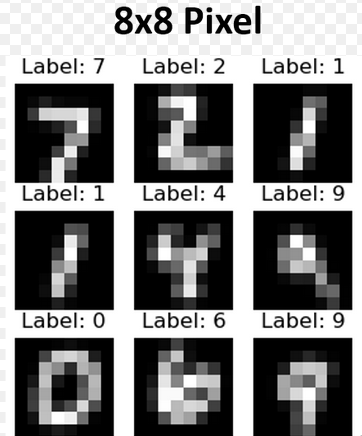

### Load local dataset

In [87]:
data = pd.read_csv('/content/digits_8x8.csv')
data.shape

(1797, 65)

In [88]:
data.head()

0    1    2     3     4     5    6    7    8    9  ...   55   56   57  \
0  0.0  0.0  5.0  13.0   9.0   1.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
1  0.0  0.0  0.0  12.0  13.0   5.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2  0.0  0.0  0.0   4.0  15.0  12.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
3  0.0  0.0  7.0  15.0  13.0   1.0  0.0  0.0  0.0  8.0  ...  0.0  0.0  0.0   
4  0.0  0.0  0.0   1.0  11.0   0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

    58    59    60    61   62   63  label  
0  6.0  13.0  10.0   0.0  0.0  0.0      0  
1  0.0  11.0  16.0  10.0  0.0  0.0      1  
2  0.0   3.0  11.0  16.0  9.0  0.0      2  
3  7.0  13.0  13.0   9.0  0.0  0.0      3  
4  0.0   2.0  16.0   4.0  0.0  0.0      4  

[5 rows x 65 columns]

In [91]:
features = data.drop('label', axis=1).values
labels = data['label'].values

### Train-test split


In [95]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

### Standardization


In [96]:
def standardize_data(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)

    # Tránh chia cho 0
    std_replaced = np.where(std == 0, 1, std)

    standardized_X = (X - mean) / std_replaced

    return standardized_X

In [97]:
X_train = standardize_data(X_train)
X_test = standardize_data(X_test)

## t-Distributed Stochastic Neighbor Embedding

### T-SNE Class

In [98]:
class Custom_TSNE:
    def __init__(
        self, n_components=2, perplexity=30.0, max_iter=200, learning_rate=500
    ):
        self.max_iter = max_iter
        self.perplexity = perplexity
        self.n_components = n_components
        self.initial_momentum = 0.5
        self.final_momentum = 0.8
        self.min_gain = 0.01
        self.lr = learning_rate
        self.tol = 1e-5
        self.perplexity_tries = 50

    def _l2_distance(self, X):
        """Tính pairwise L2 (Euclidean) distances."""
        sum_X = np.sum(np.square(X), axis=1)
        return np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)

    def _binary_search(self, dist, target_entropy):
        """Binary search để tìm ra precision."""
        precision_min = 0
        precision_max = 1.0e15
        precision = 1.0e5

        for _ in range(self.perplexity_tries):
            denom = np.sum(np.exp(-dist[dist > 0.0] / precision))
            beta = np.exp(-dist / precision) / denom

            # Exclude zeros
            g_beta = beta[beta > 0.0]
            entropy = -np.sum(g_beta * np.log2(g_beta))

            error = entropy - target_entropy

            if error > 0:
                # Decrease precision
                precision_max = precision
                precision = (precision + precision_min) / 2.0
            else:
                # Increase precision
                precision_min = precision
                precision = (precision + precision_max) / 2.0

            if np.abs(error) < self.tol:
                break

        return beta

    def _get_pairwise_affinities(self, X):
        """Tính toán độ giống nhau."""
        affines = np.zeros((self.n_samples, self.n_samples), dtype=np.float32)
        target_entropy = np.log(self.perplexity)
        distances = self._l2_distance(X)

        for i in range(self.n_samples):
            affines[i, :] = self._binary_search(distances[i], target_entropy)

        np.fill_diagonal(affines, 1.0e-12)

        affines = affines.clip(min=1e-100)
        affines = (affines + affines.T) / (2 * self.n_samples)
        return affines

    def _q_distribution(self, D):
        """Tính Student t-distribution."""
        Q = 1.0 / (1.0 + D)
        np.fill_diagonal(Q, 0.0)
        Q = Q.clip(min=1e-100)
        return Q

    def fit_transform(self, X):
        # Khởi tạo dữ liệu đầu vào
        X = np.asarray(X)
        self.n_samples = X.shape[0]

        Y = np.random.randn(self.n_samples, self.n_components)
        velocity = np.zeros_like(Y)
        gains = np.ones_like(Y)

        P = self._get_pairwise_affinities(X)

        iter_num = 0
        while iter_num < self.max_iter:
            iter_num += 1

            D = self._l2_distance(Y)
            Q = self._q_distribution(D)

            # Chuẩn hóa Q
            Q_n = Q / np.sum(Q)

            # Early exaggeration & momentum
            pmul = 4.0 if iter_num < 100 else 1.0
            momentum = 0.5 if iter_num < 20 else 0.8

            # Gradient Step
            grads = np.zeros(Y.shape)
            for i in range(self.n_samples):
                grad = 4 * np.dot((pmul * P[i] - Q_n[i]) * Q[i], Y[i] - Y)
                grads[i] = grad

            gains = (gains + 0.2) * ((grads > 0) != (velocity > 0)) + (gains * 0.8) * (
                (grads > 0) == (velocity > 0)
            )
            gains = gains.clip(min=self.min_gain)

            velocity = momentum * velocity - self.lr * (gains * grads)
            Y += velocity
            Y = Y - np.mean(Y, 0)

            error = np.sum(P * np.log(P / Q_n))
            ## Debug
            ## print("Iteration %d: error is %f" % (iter_num, error))
        return Y


### Testing t-SNE

In [32]:
custom_tsne = Custom_TSNE(perplexity=30, max_iter= 1000, n_components=2)
X_train_tsne = custom_tsne.fit_transform(X_train)
X_test_tsne = custom_tsne.fit_transform(X_test)

Iteration 1: error is 3.164388
Iteration 2: error is 2.960442
Iteration 3: error is 3.060398
Iteration 4: error is 2.979899
Iteration 5: error is 2.950543
Iteration 6: error is 2.823511
Iteration 7: error is 2.761045
Iteration 8: error is 2.568095
Iteration 9: error is 2.497088
Iteration 10: error is 2.352571
Iteration 11: error is 2.282474
Iteration 12: error is 2.171032
Iteration 13: error is 2.113142
Iteration 14: error is 2.041980
Iteration 15: error is 2.016977
Iteration 16: error is 1.947163
Iteration 17: error is 1.921676
Iteration 18: error is 1.869959
Iteration 19: error is 1.861569
Iteration 20: error is 1.819480
Iteration 21: error is 1.836008
Iteration 22: error is 1.814652
Iteration 23: error is 1.768186
Iteration 24: error is 1.741671
Iteration 25: error is 1.730199
Iteration 26: error is 1.691340
Iteration 27: error is 1.671193
Iteration 28: error is 1.645423
Iteration 29: error is 1.629922
Iteration 30: error is 1.602217
Iteration 31: error is 1.593895
Iteration 32: err

### Visualize


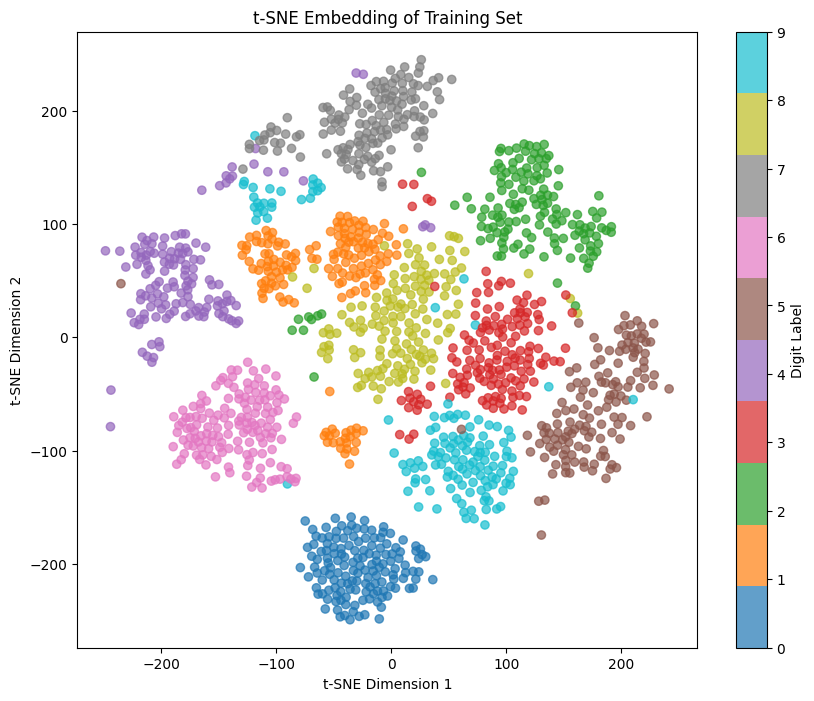

In [19]:
# Plot for t-SNE results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, cmap="tab10", alpha=0.7
)
plt.colorbar(scatter, label="Digit Label")
plt.title("t-SNE Embedding of Training Set")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

### Compare with PCA


In [41]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

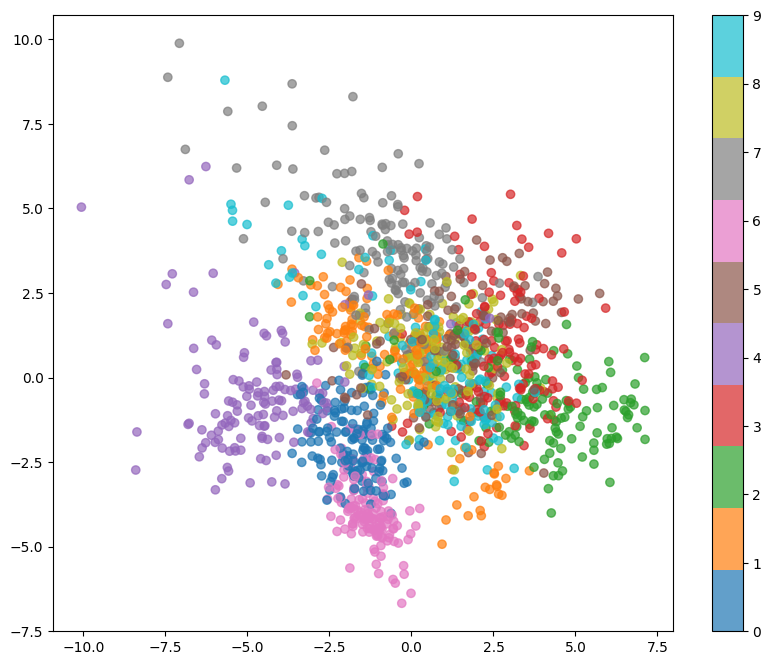

In [42]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap="tab10", alpha=0.7
)
plt.colorbar()
plt.show()

## KNN classifier

### Seting up KNN Classifier

In [99]:
knn = KNeighborsClassifier(n_neighbors=3)

### Calculating Accuracy with options perplexity = 10

#### Iteration = 10

In [100]:
custom_tsne = Custom_TSNE(perplexity=10, max_iter= 10, n_components=2)

In [101]:
X_train_tsne = custom_tsne.fit_transform(X_train)
X_test_tsne = custom_tsne.fit_transform(X_test)

In [102]:
knn.fit(X_train_tsne, y_train)

KNeighborsClassifier(n_neighbors=3)

In [103]:
y_pred = knn.predict(X_test_tsne)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

Accuracy: 0.09


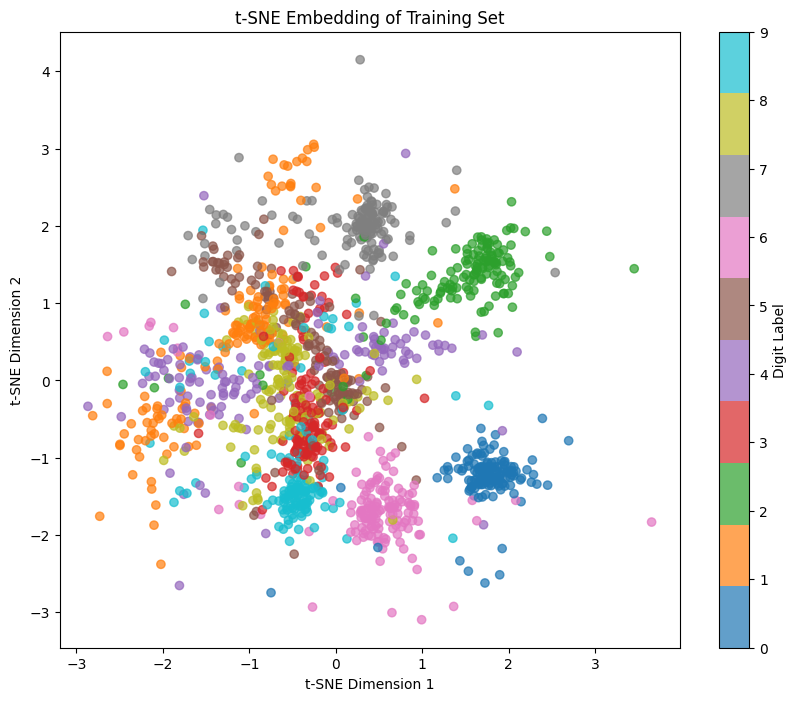

In [104]:
# Plot for t-SNE results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, cmap="tab10", alpha=0.7
)
plt.colorbar(scatter, label="Digit Label")
plt.title("t-SNE Embedding of Training Set")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

#### Iteration = 300

In [105]:
custom_tsne = Custom_TSNE(perplexity=10, max_iter= 300, n_components=2)

In [ ]:
X_train_tsne = custom_tsne.fit_transform(X_train)
X_test_tsne = custom_tsne.fit_transform(X_test)

In [ ]:
knn.fit(X_train_tsne, y_train)

In [ ]:
y_pred = knn.predict(X_test_tsne)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

In [ ]:
# Plot for t-SNE results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, cmap="tab10", alpha=0.7
)
plt.colorbar(scatter, label="Digit Label")
plt.title("t-SNE Embedding of Training Set")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

#### Iteration = 1000

In [44]:
custom_tsne = Custom_TSNE(perplexity=10, max_iter= 1000, n_components=2)

In [45]:
X_train_tsne = custom_tsne.fit_transform(X_train)
X_test_tsne = custom_tsne.fit_transform(X_test)

In [46]:
knn.fit(X_train_tsne, y_train)

KNeighborsClassifier(n_neighbors=3)

In [47]:
y_pred = knn.predict(X_test_tsne)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

Accuracy: 0.09


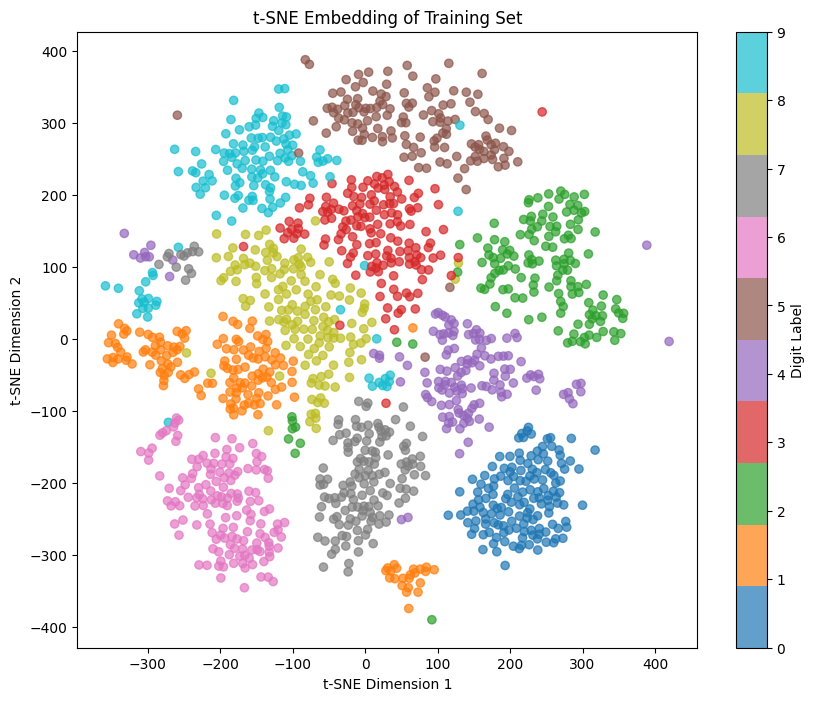

In [48]:
# Plot for t-SNE results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, cmap="tab10", alpha=0.7
)
plt.colorbar(scatter, label="Digit Label")
plt.title("t-SNE Embedding of Training Set")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

### Calculating Accuracy with options perplexity = 50

#### Iteration = 10

In [28]:
custom_tsne = Custom_TSNE(perplexity=50, max_iter= 1000, n_components=2)

In [29]:
X_train_tsne = custom_tsne.fit_transform(X_train)
X_test_tsne = custom_tsne.fit_transform(X_test)

Iteration 1: error is 3.138560
Iteration 2: error is 2.958847
Iteration 3: error is 3.043546
Iteration 4: error is 2.959983
Iteration 5: error is 2.929217
Iteration 6: error is 2.796145
Iteration 7: error is 2.730082
Iteration 8: error is 2.547534
Iteration 9: error is 2.496021
Iteration 10: error is 2.353073
Iteration 11: error is 2.281428
Iteration 12: error is 2.187210
Iteration 13: error is 2.137262
Iteration 14: error is 2.059592
Iteration 15: error is 2.027326
Iteration 16: error is 1.976220
Iteration 17: error is 1.943915
Iteration 18: error is 1.904894
Iteration 19: error is 1.880100
Iteration 20: error is 1.859823
Iteration 21: error is 1.852956
Iteration 22: error is 1.832496
Iteration 23: error is 1.796032
Iteration 24: error is 1.776349
Iteration 25: error is 1.740875
Iteration 26: error is 1.716107
Iteration 27: error is 1.695283
Iteration 28: error is 1.685367
Iteration 29: error is 1.662589
Iteration 30: error is 1.639843
Iteration 31: error is 1.632519
Iteration 32: err

In [30]:
knn.fit(X_train_tsne, y_train)

KNeighborsClassifier(n_neighbors=3)

In [31]:
y_pred = knn.predict(X_test_tsne)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

Accuracy: 0.14


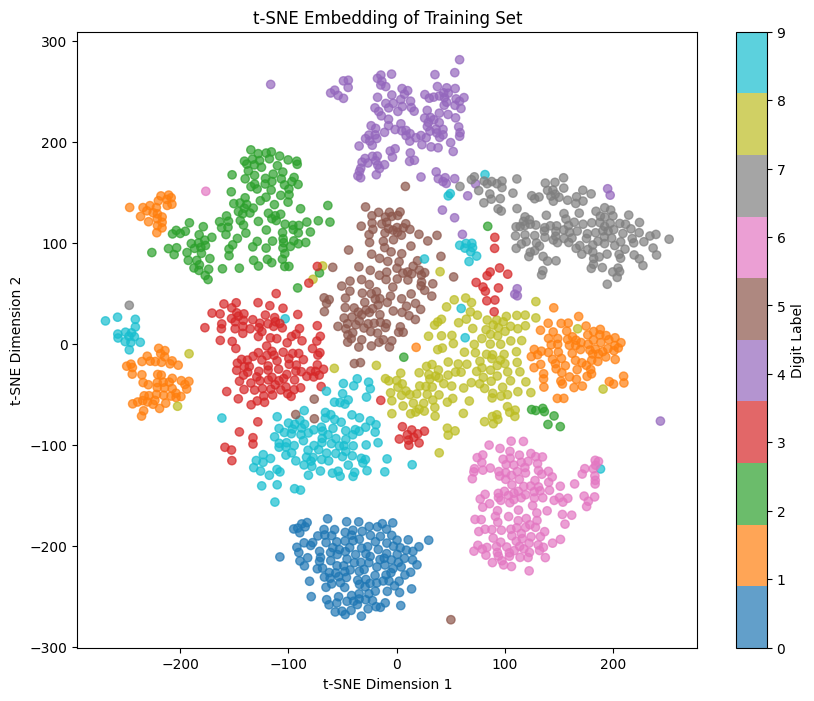

In [32]:
# Plot for t-SNE results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, cmap="tab10", alpha=0.7
)
plt.colorbar(scatter, label="Digit Label")
plt.title("t-SNE Embedding of Training Set")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

#### Iteration = 300

In [49]:
custom_tsne = Custom_TSNE(perplexity=50, max_iter= 300, n_components=2)

In [50]:
X_train_tsne = custom_tsne.fit_transform(X_train)
X_test_tsne = custom_tsne.fit_transform(X_test)

In [51]:
knn.fit(X_train_tsne, y_train)

KNeighborsClassifier(n_neighbors=3)

In [52]:
y_pred = knn.predict(X_test_tsne)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

Accuracy: 0.07


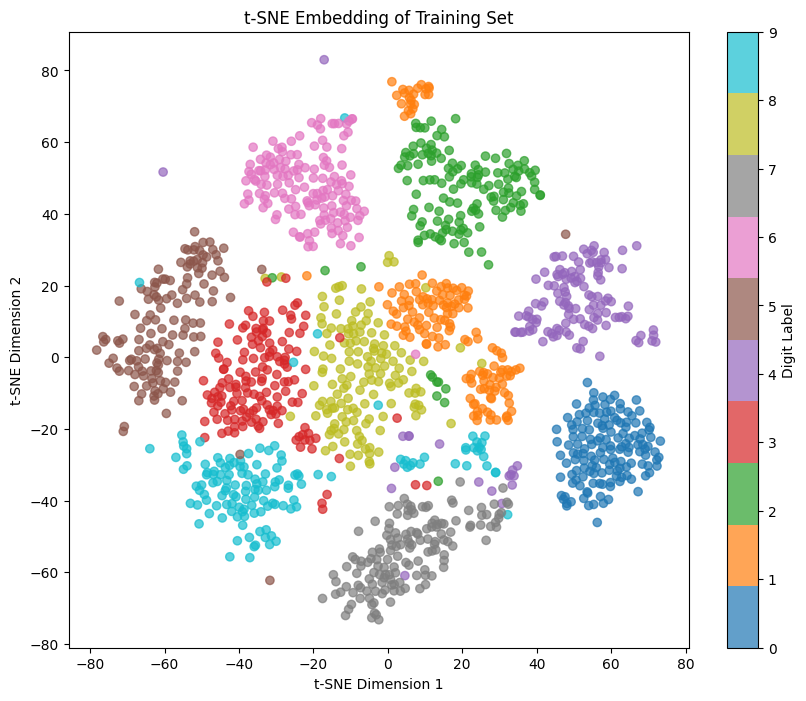

In [53]:
# Plot for t-SNE results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, cmap="tab10", alpha=0.7
)
plt.colorbar(scatter, label="Digit Label")
plt.title("t-SNE Embedding of Training Set")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

#### Iteration = 1000

In [ ]:
custom_tsne = Custom_TSNE(perplexity=50, max_iter= 1000, n_components=2)

In [ ]:
X_train_tsne = custom_tsne.fit_transform(X_train)
X_test_tsne = custom_tsne.fit_transform(X_test)

Iteration 1: error is 3.138560
Iteration 2: error is 2.958847
Iteration 3: error is 3.043546
Iteration 4: error is 2.959983
Iteration 5: error is 2.929217
Iteration 6: error is 2.796145
Iteration 7: error is 2.730082
Iteration 8: error is 2.547534
Iteration 9: error is 2.496021
Iteration 10: error is 2.353073
Iteration 11: error is 2.281428
Iteration 12: error is 2.187210
Iteration 13: error is 2.137262
Iteration 14: error is 2.059592
Iteration 15: error is 2.027326
Iteration 16: error is 1.976220
Iteration 17: error is 1.943915
Iteration 18: error is 1.904894
Iteration 19: error is 1.880100
Iteration 20: error is 1.859823
Iteration 21: error is 1.852956
Iteration 22: error is 1.832496
Iteration 23: error is 1.796032
Iteration 24: error is 1.776349
Iteration 25: error is 1.740875
Iteration 26: error is 1.716107
Iteration 27: error is 1.695283
Iteration 28: error is 1.685367
Iteration 29: error is 1.662589
Iteration 30: error is 1.639843
Iteration 31: error is 1.632519
Iteration 32: err

In [ ]:
knn.fit(X_train_tsne, y_train)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
y_pred = knn.predict(X_test_tsne)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

Accuracy: 0.14


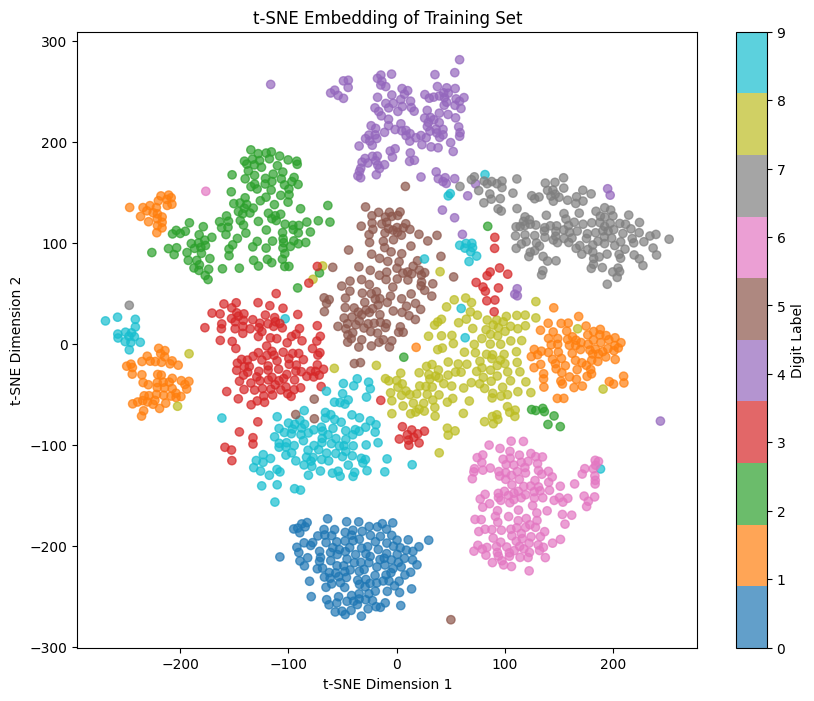

In [ ]:
# Plot for t-SNE results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, cmap="tab10", alpha=0.7
)
plt.colorbar(scatter, label="Digit Label")
plt.title("t-SNE Embedding of Training Set")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

#### Iteration = 5000

In [69]:
custom_tsne = Custom_TSNE(perplexity=50, max_iter= 5000, n_components=2)

In [70]:
X_train_tsne = custom_tsne.fit_transform(X_train)
X_test_tsne = custom_tsne.fit_transform(X_test)

In [71]:
knn.fit(X_train_tsne, y_train)

KNeighborsClassifier(n_neighbors=3)

In [72]:
y_pred = knn.predict(X_test_tsne)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

Accuracy: 0.23


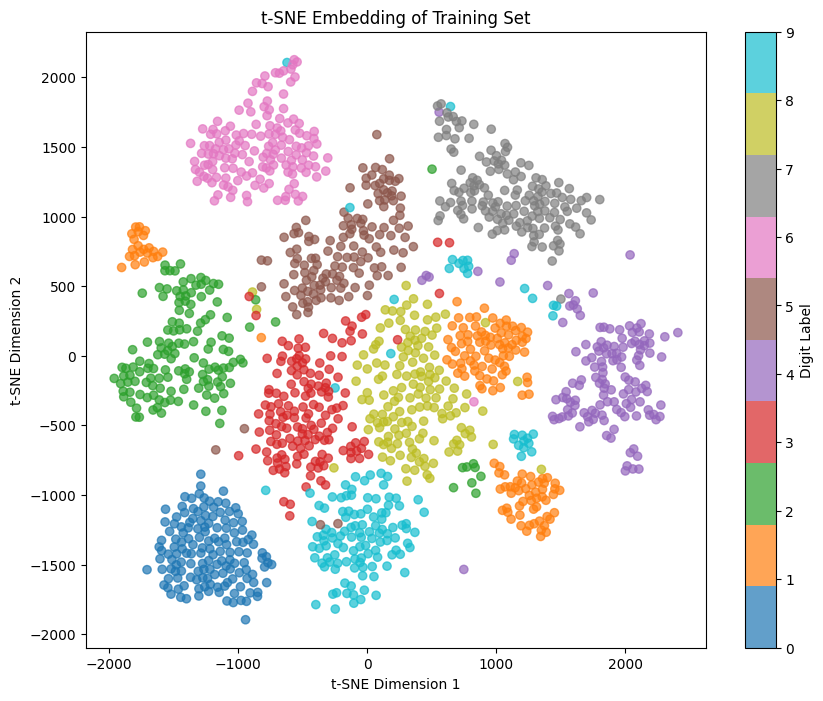

In [73]:
# Plot for t-SNE results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, cmap="tab10", alpha=0.7
)
plt.colorbar(scatter, label="Digit Label")
plt.title("t-SNE Embedding of Training Set")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

### Calculating Accurary with options perplexity = 100

#### Iteration = 10

In [17]:
custom_tsne = Custom_TSNE(perplexity=100, max_iter= 10, n_components=2)

In [18]:
X_train_tsne = custom_tsne.fit_transform(X_train)
X_test_tsne = custom_tsne.fit_transform(X_test)

Iteration 1: error is 3.108805
Iteration 2: error is 2.904458
Iteration 3: error is 3.015959
Iteration 4: error is 2.911900
Iteration 5: error is 2.903982
Iteration 6: error is 2.756427
Iteration 7: error is 2.724808
Iteration 8: error is 2.526619
Iteration 9: error is 2.474356
Iteration 10: error is 2.316248
Iteration 11: error is 2.276828
Iteration 12: error is 2.151245
Iteration 13: error is 2.124801
Iteration 14: error is 2.022642
Iteration 15: error is 2.018361
Iteration 16: error is 1.932613
Iteration 17: error is 1.938277
Iteration 18: error is 1.877013
Iteration 19: error is 1.880515
Iteration 20: error is 1.826872
Iteration 21: error is 1.835912
Iteration 22: error is 1.818387
Iteration 23: error is 1.766497
Iteration 24: error is 1.756622
Iteration 25: error is 1.731433
Iteration 26: error is 1.709440
Iteration 27: error is 1.679719
Iteration 28: error is 1.679958
Iteration 29: error is 1.647919
Iteration 30: error is 1.635219
Iteration 31: error is 1.625249
Iteration 32: err

In [20]:
knn.fit(X_train_tsne, y_train)

KNeighborsClassifier(n_neighbors=3)

In [21]:
y_pred = knn.predict(X_test_tsne)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

Accuracy: 0.01


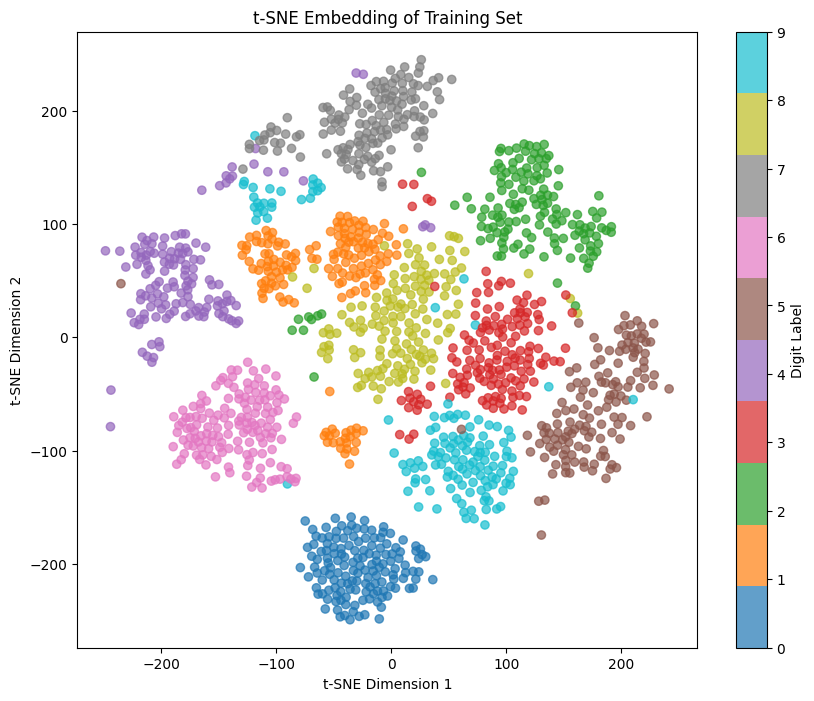

In [22]:
# Plot for t-SNE results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, cmap="tab10", alpha=0.7
)
plt.colorbar(scatter, label="Digit Label")
plt.title("t-SNE Embedding of Training Set")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

#### Iteration = 300

In [64]:
custom_tsne = Custom_TSNE(perplexity=100, max_iter= 300, n_components=2)

In [65]:
X_train_tsne = custom_tsne.fit_transform(X_train)
X_test_tsne = custom_tsne.fit_transform(X_test)

In [66]:
knn.fit(X_train_tsne, y_train)

KNeighborsClassifier(n_neighbors=3)

In [67]:
y_pred = knn.predict(X_test_tsne)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

Accuracy: 0.18


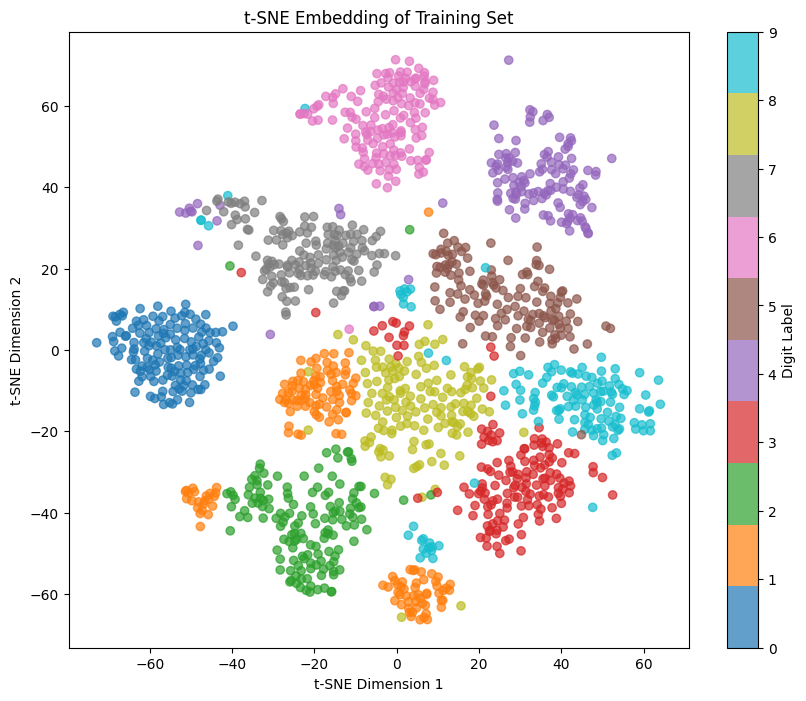

In [68]:
# Plot for t-SNE results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, cmap="tab10", alpha=0.7
)
plt.colorbar(scatter, label="Digit Label")
plt.title("t-SNE Embedding of Training Set")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

#### Iteration = 1000

In [54]:
custom_tsne = Custom_TSNE(perplexity=100, max_iter= 1000, n_components=2)

In [55]:
X_train_tsne = custom_tsne.fit_transform(X_train)
X_test_tsne = custom_tsne.fit_transform(X_test)

In [56]:
knn.fit(X_train_tsne, y_train)

KNeighborsClassifier(n_neighbors=3)

In [57]:
y_pred = knn.predict(X_test_tsne)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

Accuracy: 0.06


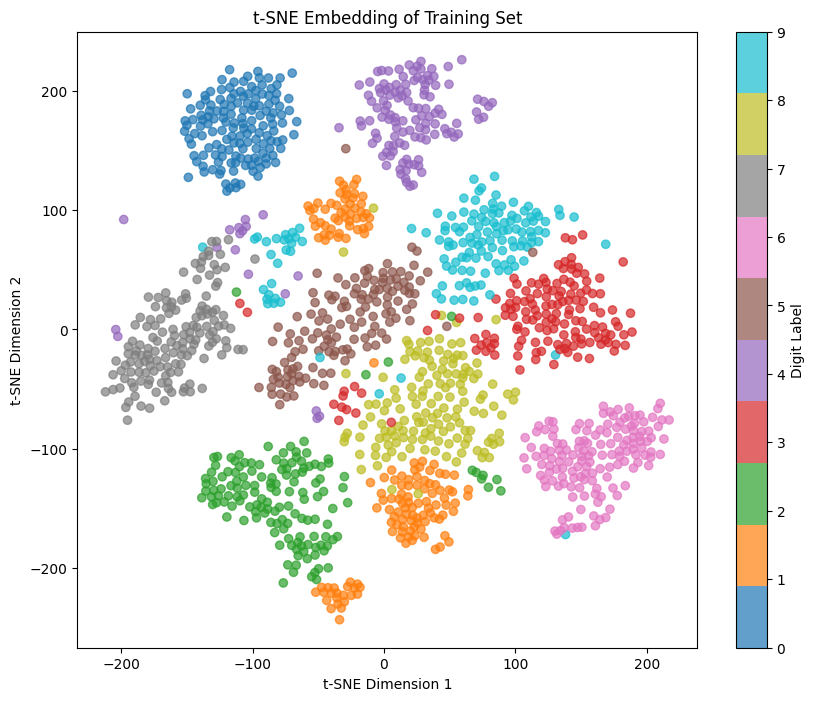

In [58]:
# Plot for t-SNE results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, cmap="tab10", alpha=0.7
)
plt.colorbar(scatter, label="Digit Label")
plt.title("t-SNE Embedding of Training Set")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()